# Created my own model 
## Inspired by Dilated Net and Large Kernel Matters Papers
### Uses Large Kernels at the Ending layers
### Uses Dilated Convolutions and Transposed Convolutions
### Reduces False Positives to a great extent
### Best results on test set among all trained models
### The test outputs are shown below
### The model is pretrained on existing set and then finetuned on augmented data
### The model is overfitted on existing set and then finetuned on augumented data
### The output contains the smoothed output and thresholded output with the test image

#### Do not run the code ! 

In [3]:

from keras.models import Model, Sequential
from keras.layers import *
import numpy as np
import keras.backend as K
from keras.optimizers import *
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Dropout, merge
import numpy as np
import keras.backend as K
from keras.optimizers import *
from keras.losses import binary_crossentropy,categorical_crossentropy
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.layers import concatenate,Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
train = np.load('/home/ubuntu/MobileExtraction/Train-color.npy')
labels = np.load('/home/ubuntu/MobileExtraction/Labels-color.npy')
'''x = np.argwhere(labels>0)
print(x.shape)
for i in range(x.shape[0]):
    labels[x[i][0],x[i][1],x[i][2]] = 1
train = train.reshape(347,256,324,1)'''
train = train/255.
labels = labels/255
#labels = labels.reshape(347,256,324,1)
labels = to_categorical(labels)
print(np.unique(labels))
import tensorflow as tf
print(labels.shape)
print(train.shape)
labels=labels.astype('uint8')
smooth = 1.
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=1)
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred)-K.log(dice_coef(y_true, y_pred))

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
inputs = Input((3,256,256))
x = Conv2D(filters=32,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(inputs)
x = Conv2D(filters=32,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',kernel_initializer='he_normal')(x)
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',kernel_initializer='he_normal')(x)
x = Conv2D(filters=128,activation='relu',kernel_size=(1,1),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=128,activation='relu',kernel_size=(1,1),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=2,activation='softmax',kernel_size=(1,1),padding='same',kernel_regularizer=l2(1e-4))(x)
model = Model(inputs=inputs,outputs=x)

[0. 1.]


/home/ubuntu/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/ubuntu/.local/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


(1314, 256, 256, 2)
(1314, 256, 256, 3)


/usr/local/lib/python3.5/dist-packages/keras/backend/mxnet_backend.py:89: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/usr/local/lib/python3.5/dist-packages/keras/backend/mxnet_backend.py:92: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input

MXNetError: Error in operator max_pooling2d_2/pool2d1: [12:14:27] src/operator/nn/pooling.cc:141: Check failed: param.kernel[0] <= dshape[2] + 2 * param.pad[0] kernel size (2) exceeds input (1 padded to 1)

Stack trace returned 10 entries:
[bt] (0) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x30cbe2) [0x7f174333dbe2]
[bt] (1) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x30d1b8) [0x7f174333e1b8]
[bt] (2) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x6ca815) [0x7f17436fb815]
[bt] (3) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x299b76f) [0x7f17459cc76f]
[bt] (4) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x299e2d0) [0x7f17459cf2d0]
[bt] (5) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(MXSymbolInferShape+0x1549) [0x7f174594d169]
[bt] (6) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(MXSymbolInferShapePartial+0x82) [0x7f174594e922]
[bt] (7) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(ffi_call_unix64+0x4c) [0x7f179ef43e20]
[bt] (8) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(ffi_call+0x2eb) [0x7f179ef4388b]
[bt] (9) /usr/lib/python3.5/lib-dynload/_ctypes.cpython-35m-x86_64-linux-gnu.so(_ctypes_callproc+0x49a) [0x7f179ef3e01a]



/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


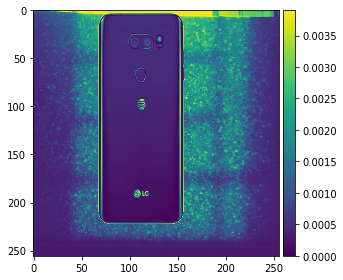

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
__________

array([0, 1], dtype=uint8)

In [2]:
from skimage import io
io.imshow(train[90,:,:,0])
io.show()
model.summary()
np.unique(labels)

In [3]:
model.compile(optimizer=Adam(lr=1e-3,decay=1e-4), loss='categorical_crossentropy', metrics=[dice_coef,jacard_coef])

In [ ]:
checkpoint = ModelCheckpoint(filepath='/home/ubuntu/MobileExtraction/dilated512-run1.h5',mode='max',
                             monitor='val_dice_coef',verbose=1,save_best_only=True)
#model.load_weights('/home/ubuntu/MobileExtraction/dilated512-run1.h5')
data_gen_args = dict(horizontal_flip=True,vertical_flip=True,
                     rotation_range=90.,
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(train, augment=True, seed=seed)


# combine generators into one which yields image and masks
train_generator = zip(image_datagen.flow(x=train,batch_size=1,seed=1), mask_datagen.flow(x=labels,batch_size=1,seed=1))
valid_generator = zip(image_datagen.flow(x=train,batch_size=1,seed=1), mask_datagen.flow(x=labels,batch_size=1,seed=1))
model.fit_generator(callbacks=[checkpoint],validation_data=[train[1000:],labels[1000:]],validation_steps=90,
    generator=train_generator,
    steps_per_epoch=1000,
    epochs=100)

In [ ]:
from skimage import io as skio
import matplotlib.pyplot as io
from glob import glob
import cv2 as cv
testPath = glob('/home/ubuntu/Desktop/Air-Data/**/**.jpg')
for i in range(len(testPath)):
    #tokens = testPath[i].split('/')
    #name = tokens[6].split('.')[0]
    img = skio.imread(testPath[i])
    print(img.shape)
    img = np.asarray(img).astype('float32')
    img = cv.resize(img,dsize=(256,256),interpolation=cv.INTER_AREA)
    print(img.shape)
    #label = cv.resize(label,dsize=(324,256))

    #label = label.astype('uint8')
    img = img.reshape(1,256,256,3)
    print(img.shape)
    img = img/255.
    #label = label.reshape(512,648,1)
    print(img.shape)
    skio.imshow(img[0,:,:,0])
    skio.show()
    #img = (img-np.mean(img))/np.std(img)
    predicted = model.predict(img)
    print(predicted.shape)
    io.imshow(predicted[0,:,:,1])
    io.show()
    thresh = np.argwhere(predicted[:,:,:,1]>0.1)
    img = np.zeros((256,256)).astype('uint8')
    print(thresh.shape)
    for i in range(thresh.shape[0]):
        img[thresh[i][1],thresh[i][2]]=255
    
    skio.imshow(img)
    skio.show()

In [ ]:
img = img.reshape(256,324)

In [ ]:
imgss = cv.resize(img,(2592,2048),interpolation=cv.INTER_AREA)

In [ ]:
img  = img/255.
img = (img-np.mean(img))/np.std(img)

In [ ]:
io.imshow(imgss)
io.show()
io.imshow(img1)
io.show()

In [ ]:
ones = np.argwhere(imgss==255)

In [ ]:
model.evaluate(train,labels,batch_size=1,verbose=1)

In [ ]:
twos = np.argwhere(labels==2)

In [ ]:
for i in range(twos.shape[0]):
    labels[twos[i][0],twos[i][1],twos[i][2],0] = 1
    print(i)

In [ ]:
np.save(arr=labels,file='/home/ubuntu/MobileExtraction/Labels512x648.npy')

In [ ]:
np.mean(train)

In [ ]:
thresh

In [ ]:
from skimage import io as skio
import matplotlib.pyplot as io
from glob import glob
testPath = glob('/home/ubuntu/Desktop/Air-Data/**/**.jpg')
for i in xrange(len(testPath)):
    tokens = testPath[i].split('/')
    name = tokens[6].split('.')[0]
    img = skio.imread(testPath[i])
    io.imshow(img)
    io.show()
    img  = img/255.
    img = (img-np.mean(img))/np.std(img)
    if img.shape==(320,480,3):
        print 'yes'
    else:
        img = img.transpose([1,0,2])
    img = img.reshape(1,320,480,3)
    predicted = model.predict(img)
    predicted = predicted.transpose([0,3,1,2])
    io.imshow(predicted[0][0])
    io.show()
    thresh = np.argwhere(predicted>0.000001)
    for i in xrange(thresh.shape[0]):
        predicted[thresh[i][0],thresh[i][1],thresh[i][2],thresh[i][3]]=255
    
    io.imshow(predicted[0][0])
    io.show()
    predicted.shape

In [ ]:
x = np.argwhere(predicted[0,:,:,1]<predicted[0,:,:,0])

In [ ]:
sudo scp -r /home/ubuntu/Desktop/colour_data/train_data/ ubuntu@172.16.1.254:/home/ubuntu/Music/
x.shapefrom skimage import io as skio
import matplotlib.pyplot as io
from glob import glob
testPath = glob('/home/ubuntu/Desktop/Air-Data/**/**.jpg')
for i in xrange(len(testPath)):
    tokens = testPath[i].split('/')
    name = tokens[6].split('.')[0]
    img = skio.imread(testPath[i])
    io.imshow(img)
    io.show()
    img  = img/255.
    img = (img-np.mean(img))/np.std(img)
    if img.shape==(320,480,3):
        print 'yes'
    else:
        img = img.transpose([1,0,2])
    img = img.reshape(1,320,480,3)
    predicted = model.predict(img)
    predicted = predicted.transpose([0,3,1,2])
    io.imshow(predicted[0][0])
    io.show()
    thresh = np.argwhere(predicted>0.000001)
    for i in xrange(thresh.shape[0]):
        predicted[thresh[i][0],thresh[i][1],thresh[i][2],thresh[i][3]]=255
    
    io.imshow(predicted[0][0])
    io.show()
    

In [ ]:
()x

In [ ]:
img = np.zeros((256,324)).astype('float32')

In [ ]:
for i in range(x.shape[0]):
    img[x[0],x[1]]=255

In [ ]:
np.argwhere(x>0)

In [ ]:
img = skio.imread(testPath[i])

In [ ]:
img.shape

In [ ]:
len(ones)

In [ ]:
imgss.shape

In [ ]:
img1.shape

In [ ]:
z = imgss/img1


In [ ]:
io.imshow(z)